# HMDA analysis

## Getting data

In [1]:
# imports
import pandas as pd
import numpy as np
import urllib,json

The dataset have been browsed in order to understand its contents. The fields are defined at http://cfpb.github.io/api/hmda/fields.html and there is a numerical index for every property. The fields with numerical indices have been selected to be saved. For the race, only the first reported race for applicant and co-applicant has been saved.

In [2]:
collumns=['action_taken',
 'agency_code',
 'applicant_ethnicity',
 'applicant_income_000s',
 'applicant_race_1',
 'applicant_sex',
 'application_date_indicator',
 'co_applicant_ethnicity',
 'co_applicant_race_1',
 'co_applicant_sex',
 'county_code',
 'edit_status',
 'hoepa_status',
 'hud_median_family_income',
 'lien_status',
 'loan_amount_000s',
 'loan_purpose',
 'minority_population',
 'msamd',
 'number_of_1_to_4_family_units',
 'number_of_owner_occupied_units',
 'population',
 'preapproval',
 'property_type',
 'purchaser_type',
 'respondent_id',
 'sequence_number',
 'tract_to_msamd_income']

Using the GUI to download csv file using filters defined in https://www.consumerfinance.gov/data-research/hmda/explore#!/as_of_year=2015&state_code-1=6&property_type=1,2&owner_occupancy=1&section=filters. The selection is
   * state California
   * year 2015
   * property type: 1-4 family dwelling and manufactured houses
   * owner-occupied principal residence

In [68]:
df=pd.read_csv('/home/jpavel/Downloads/hmda_lar (1).csv')

Select only numerical columns

In [69]:
df=df[collumns]

In [6]:
# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
%matplotlib inline

Explore the labels:

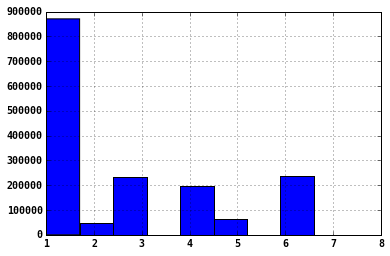

In [7]:
df['action_taken'].hist()

In [5]:
df.groupby('action_taken').size()

action_taken
1    870734
2     48449
3    232864
4    198680
5     62971
6    238717
7        53
8       176
dtype: int64

The goal is to find which applications were approved, which means the actions 1 ("loan originated") and 2 ("approved but not accepted"). Therefore a new field giving a binary value approved/not approved was created

In [70]:
df['approved']=(df['action_taken']<3)

Check the data balance wrt the 2 labels we would like to predict:

In [71]:
df['approved'].mean()

0.55618935475516806

Data, overall, are reasonably well balanced. Let's check into some demography categories:

In [10]:
df.groupby('applicant_sex')['approved'].agg({np.mean,np.std})

,std,mean
applicant_sex,,
1,0.489428,0.602276
2,0.492926,0.583813
3,0.499559,0.521041
4,0.077303,0.006012


In [72]:
# make a dictionary to convert the indices above to names
import pycurl
from StringIO import StringIO

In [73]:
def getDictFromAPI(url):
    """Little function to query the API, extract the table from JSON and save as dictionary"""
    storage = StringIO()
    c = pycurl.Curl()
    c.setopt(c.URL, url)
    c.setopt(c.WRITEFUNCTION, storage.write)
    c.perform()
    apijson=json.loads(storage.getvalue())
    tempDF=pd.io.json.json_normalize(apijson['table']['data'])
    out_dict=tempDF.set_index('_id').to_dict()
    return out_dict['name']

In [74]:
sex_dict=getDictFromAPI('https://api.consumerfinance.gov/data/hmda/concept/sex.json')

In [75]:
df.groupby('applicant_sex')['approved'].agg({np.mean,np.std}).rename_axis(sex_dict)

,std,mean
applicant_sex,,
Male,0.481204,0.635803
Female,0.485971,0.617611
"Information not provided by applicant in mail, Internet, or telephone application",0.497880,0.546022
Not applicable,0.078110,0.006139


**Observation 1**:

Males have slightly higher chance to get loan approved than females and in general it seems beneficial to declare sex. People who did declare different sex than M or F had very small chance of getting loan

Similarly, get a dictionary from api, that would convert race index to human understandable names:

In [76]:
race_dict=getDictFromAPI('https://api.consumerfinance.gov/data/hmda/concept/race.json')

In [77]:
df.pivot_table(values='approved',index=['applicant_race_1'],columns=['applicant_sex'],aggfunc=np.mean).rename_axis(race_dict).rename_axis(sex_dict,axis=1) 

applicant_sex,Male,Female,"Information not provided by applicant in mail, Internet, or telephone application",Not applicable
applicant_race_1,,,,
American Indian or Alaska Native,0.518355,0.511100,0.649254,0.600000
Asian,0.663046,0.634959,0.683342,0.916667
Black or African American,0.544804,0.538497,0.727273,1.000000
Native Hawaiian or Other Pacific Islander,0.582024,0.537911,0.452830,1.000000
White,0.644497,0.631270,0.618657,0.918367
"Information not provided by applicant in mail, Internet, or telephone application",0.570243,0.552092,0.541366,0.490566
Not applicable,0.783217,0.865385,0.666667,0.005405


White and Asian people have somehow higher chance to get loan approved than american natives or black/african americans.

## Missing values
Now check if there are missing values and fix it

In [6]:
for colname in df.columns:
    print str(colname)+' : '+str(df[colname].isnull().sum()/float(len(df.index)))

action_taken : 0.0
agency_code : 0.0
applicant_ethnicity : 0.0
applicant_income_000s : 0.165100287781
applicant_race_1 : 0.0
applicant_sex : 0.0
application_date_indicator : 0.0
co_applicant_ethnicity : 0.0
co_applicant_race_1 : 0.0
co_applicant_sex : 0.0
county_code : 0.00170151587396
edit_status : 0.817657039266
hoepa_status : 0.0
hud_median_family_income : 0.00245969488892
lien_status : 0.0
loan_amount_000s : 0.0
loan_purpose : 0.0
minority_population : 0.00246695598084
msamd : 0.0199492449675
number_of_1_to_4_family_units : 0.00250265634946
number_of_owner_occupied_units : 0.00265816473481
population : 0.0024609050709
preapproval : 0.0
property_type : 0.0
purchaser_type : 0.0
respondent_id : 0.0
sequence_number : 0.0
tract_to_msamd_income : 0.00259947090844
approved : 0.0


Third column is income - let's  have a look:

In [7]:
def checkNullValues(inDF):
    for colname in inDF.columns:
        print str(colname)+' : '+str(inDF[colname].isnull().sum()/float(len(inDF.index)))

In [22]:
df.groupby('approved')[df.columns[3]].describe()

approved       
False     count    576746.000000
          mean        121.772094
          std         172.105663
          min           1.000000
          25%          60.000000
          50%          90.000000
          75%         140.000000
          max        9999.000000
True      count    803046.000000
          mean        137.272358
          std         164.840898
          min           1.000000
          25%          70.000000
          50%         104.000000
          75%         158.000000
          max        9999.000000
Name: applicant_income_000s, dtype: float64

Max value seems weird, so let's have a look in more detail:

In [23]:
df[(df[df.columns[3]]<9999)&(df[df.columns[3]]>9000)][df.columns[3]]

313838     9426.0
448454     9929.0
565516     9759.0
815162     9593.0
833510     9509.0
885719     9493.0
976132     9512.0
1171535    9600.0
1203143    9153.0
1338490    9600.0
Name: applicant_income_000s, dtype: float64

Ok, it makes sense - it is California, so there can be people with yearly income over 10M USD - I suppose there is fixed limit of 4 digits so all people with 5 digit income are denoted with 4 9's

In [24]:
df.groupby('edit_status')['approved'].describe()

edit_status        
6.0          count     301348
             unique         2
             top         True
             freq      162085
Name: approved, dtype: object

In [25]:
df[df['edit_status'].notnull()]['edit_status'].mean()

6.0

In [26]:
df[df['edit_status'].notnull()]['edit_status'].std()

0.0

So some (aboit 20 % have "quality edit failure only"). The rest I suppose no problem. Just check if it is not an artefact of casting:

In [27]:
pd.read_csv("/home/jpavel/Downloads/hmda_lar (1).csv")['edit_status_name'].isnull().sum()/float(len(df.index))

0.81765703926556477

Replace NaN by zero, as it is actually an information (no quality problem)

In [78]:
df['edit_status']=df['edit_status'].fillna(0)

What to do with msda?

In [9]:
df.groupby('msamd')['approved'].mean()

msamd
11244.0    0.538852
12540.0    0.491411
17020.0    0.549975
20940.0    0.483715
23420.0    0.507335
25260.0    0.460321
31084.0    0.509157
31460.0    0.471531
32900.0    0.476778
33700.0    0.510753
34900.0    0.527782
36084.0    0.559508
37100.0    0.546241
39820.0    0.490124
40140.0    0.490166
40900.0    0.532649
41500.0    0.508505
41740.0    0.547635
41884.0    0.601602
41940.0    0.579035
42020.0    0.541239
42034.0    0.590975
42100.0    0.554229
42200.0    0.544421
42220.0    0.579898
44700.0    0.510135
46700.0    0.515859
47300.0    0.471853
49700.0    0.490152
Name: approved, dtype: float64

In [10]:
df[df[df.columns[3]].isnull()]['approved'].mean()

0.2480758799642297

There is a significant smaller chance of getting a loan approved for somebody whose income is unknown - it should be encoded in the data

In [79]:
df[df['hud_median_family_income'].isnull()]['approved'].mean()

0.1965559655596556

Now split the dataset for those with defined income and those without

In [80]:
df['hasDefinedIncome']=df['applicant_income_000s'].notnull()

In [81]:
df['hasDefinedIncome'].mean()

0.8348997122187235

The strategy for replacing the missing values will be:
    1) for categorical ones - the missing value will be a category
    2) for continuous ones - create another variable describing if variable is defined or not, and withing the variable replace by mean to do not change the mean of the variable

In [82]:
def fillNAwithMean(colname):
    df[str('hasDefined'+colname)]=df[colname].notnull()
    mean=df[colname].mean()
    df[colname]=df[colname].fillna(mean)

In [83]:
fillNAwithMean('applicant_income_000s')

In [84]:
df['county_code']=df['county_code'].fillna(0)

In [85]:
df['hasDefinedHUDMedianIncome']=df['hud_median_family_income'].notnull()

In [86]:
fillNAwithMean('hud_median_family_income')

In [87]:
df['hasDefined_minority_population']=df['minority_population'].notnull()

In [88]:
fillNAwithMean('minority_population')

In [89]:
df['msamd']=df['msamd'].fillna(0)

In [90]:
fillNAwithMean('number_of_1_to_4_family_units')

In [91]:
fillNAwithMean('number_of_owner_occupied_units')

In [92]:
fillNAwithMean('population')

In [93]:
fillNAwithMean('tract_to_msamd_income')

Now there are no missing values in the data frame. Let's transform categories into dummy variables:

In [94]:
checkNullValues(df)

action_taken : 0.0
agency_code : 0.0
applicant_ethnicity : 0.0
applicant_income_000s : 0.0
applicant_race_1 : 0.0
applicant_sex : 0.0
application_date_indicator : 0.0
co_applicant_ethnicity : 0.0
co_applicant_race_1 : 0.0
co_applicant_sex : 0.0
county_code : 0.0
edit_status : 0.0
hoepa_status : 0.0
hud_median_family_income : 0.0
lien_status : 0.0
loan_amount_000s : 0.0
loan_purpose : 0.0
minority_population : 0.0
msamd : 0.0
number_of_1_to_4_family_units : 0.0
number_of_owner_occupied_units : 0.0
population : 0.0
preapproval : 0.0
property_type : 0.0
purchaser_type : 0.0
respondent_id : 0.0
sequence_number : 0.0
tract_to_msamd_income : 0.0
approved : 0.0
hasDefinedIncome : 0.0
hasDefinedapplicant_income_000s : 0.0
hasDefinedHUDMedianIncome : 0.0
hasDefinedhud_median_family_income : 0.0
hasDefined_minority_population : 0.0
hasDefinedminority_population : 0.0
hasDefinednumber_of_1_to_4_family_units : 0.0
hasDefinednumber_of_owner_occupied_units : 0.0
hasDefinedpopulation : 0.0
hasDefined

In [47]:
df.columns

Index([u'action_taken', u'agency_code', u'applicant_ethnicity',
       u'applicant_income_000s', u'applicant_race_1', u'applicant_sex',
       u'application_date_indicator', u'co_applicant_ethnicity',
       u'co_applicant_race_1', u'co_applicant_sex', u'county_code',
       u'edit_status', u'hoepa_status', u'hud_median_family_income',
       u'lien_status', u'loan_amount_000s', u'loan_purpose',
       u'minority_population', u'msamd', u'number_of_1_to_4_family_units',
       u'number_of_owner_occupied_units', u'owner_occupancy', u'population',
       u'preapproval', u'property_type', u'purchaser_type', u'respondent_id',
       u'sequence_number', u'tract_to_msamd_income', u'approved',
       u'hasDefinedIncome', u'hasDefinedapplicant_income_000s',
       u'hasDefinedHUDMedianIncome', u'hasDefinedhud_median_family_income',
       u'hasDefined_minority_population', u'hasDefinedminority_population',
       u'hasDefinednumber_of_1_to_4_family_units',
       u'hasDefinednumber_of_owner_occ

In [95]:
vars_cat=['agency_code','application_date_indicator','applicant_ethnicity','applicant_race_1','applicant_sex','co_applicant_ethnicity','co_applicant_race_1',
          'co_applicant_sex','county_code','edit_status','hoepa_status','lien_status','loan_purpose','msamd','preapproval',
          'property_type','purchaser_type','respondent_id'
         ]
# dropped variables with >10 categories
vars_cat2=['agency_code','application_date_indicator','applicant_ethnicity','applicant_race_1','applicant_sex','co_applicant_ethnicity','co_applicant_race_1',
          'co_applicant_sex','edit_status','hoepa_status','lien_status','loan_purpose','preapproval',
          'property_type','purchaser_type'
         ]

In [109]:
# dropped variables with >10 categories
vars_cat3=['agency_code','application_date_indicator','applicant_ethnicity','applicant_race_1','applicant_sex','co_applicant_ethnicity','co_applicant_race_1',
          'co_applicant_sex','edit_status','hoepa_status','lien_status','loan_purpose','preapproval',
          'property_type'
         ]

In [24]:
vars_cont=['applicant_income_000s','hud_median_family_income','loan_amount_000s','minority_population','number_of_1_to_4_family_units',
           'number_of_owner_occupied_units','population','tract_to_msamd_income']

Truncating unnecessary columns - action_taken (transferred to approved), owner_occupance (used for data slice selection), sequence_number (random application number)

In [96]:
cols_remove=['action_taken','sequence_number']
def deleteCols(inDF,cols):
    outDF=inDF
    for col in cols:
        del outDF[col]
    
    return outDF

In [97]:
df_pruned=df

In [98]:
df_pruned=deleteCols(df_pruned,cols_remove)

In [28]:
df_cat=pd.get_dummies(df_pruned,columns=vars_cat)

In [54]:
df_cat.columns

Index([u'applicant_income_000s', u'hud_median_family_income',
       u'loan_amount_000s', u'minority_population',
       u'number_of_1_to_4_family_units', u'number_of_owner_occupied_units',
       u'population', u'tract_to_msamd_income', u'approved',
       u'hasDefinedIncome',
       ...
       u'respondent_id_95-4535105', u'respondent_id_95-4575252',
       u'respondent_id_95-4588714', u'respondent_id_95-4623407',
       u'respondent_id_95-4762204', u'respondent_id_95-4769926',
       u'respondent_id_95-4830207', u'respondent_id_95-4866828',
       u'respondent_id_99-0021801', u'respondent_id_99-0022441'],
      dtype='object', length=1310)

In [55]:
for col in df_cat.columns:
    print col

applicant_income_000s
hud_median_family_income
loan_amount_000s
minority_population
number_of_1_to_4_family_units
number_of_owner_occupied_units
population
tract_to_msamd_income
approved
hasDefinedIncome
hasDefinedapplicant_income_000s
hasDefinedHUDMedianIncome
hasDefinedhud_median_family_income
hasDefined_minority_population
hasDefinedminority_population
hasDefinednumber_of_1_to_4_family_units
hasDefinednumber_of_owner_occupied_units
hasDefinedpopulation
hasDefinedtract_to_msamd_income
agency_code_1
agency_code_2
agency_code_3
agency_code_5
agency_code_7
agency_code_9
application_date_indicator_0
application_date_indicator_1
application_date_indicator_2
applicant_ethnicity_1
applicant_ethnicity_2
applicant_ethnicity_3
applicant_ethnicity_4
applicant_race_1_1
applicant_race_1_2
applicant_race_1_3
applicant_race_1_4
applicant_race_1_5
applicant_race_1_6
applicant_race_1_7
applicant_sex_1
applicant_sex_2
applicant_sex_3
applicant_sex_4
co_applicant_ethnicity_1
co_applicant_ethnicity_2
co

In [99]:
df_pruned.corr()['approved']

agency_code                                -0.107439
applicant_ethnicity                        -0.297316
applicant_income_000s                       0.040877
applicant_race_1                           -0.225042
applicant_sex                              -0.337292
application_date_indicator                 -0.459983
co_applicant_ethnicity                     -0.104398
co_applicant_race_1                        -0.106030
co_applicant_sex                           -0.108698
county_code                                 0.008293
edit_status                                 0.011782
hoepa_status                               -0.005898
hud_median_family_income                    0.055690
lien_status                                -0.460717
loan_amount_000s                            0.053153
loan_purpose                               -0.058896
minority_population                        -0.058507
msamd                                       0.016724
number_of_1_to_4_family_units               0.

In [100]:
# prepare data without extensive categories
df_cat2=pd.get_dummies(df_pruned,columns=vars_cat2)

In [101]:
deleteCols(df_cat2,['msamd','county_code'])

,applicant_income_000s,hud_median_family_income,loan_amount_000s,minority_population,number_of_1_to_4_family_units,number_of_owner_occupied_units,population,respondent_id,tract_to_msamd_income,approved,...,purchaser_type_0,purchaser_type_1,purchaser_type_2,purchaser_type_3,purchaser_type_4,purchaser_type_5,purchaser_type_6,purchaser_type_7,purchaser_type_8,purchaser_type_9
0,199.000000,96900.000000,1100,59.950001,1564.000000,639.000000,4996.000000,0000451965,103.559998,True,...,1,0,0,0,0,0,0,0,0,0
1,98.000000,60500.000000,417,52.970001,1169.000000,1038.000000,4255.000000,0000504713,172.570007,True,...,0,0,0,1,0,0,0,0,0,0
2,73.000000,47600.000000,255,68.769997,1109.000000,882.000000,4605.000000,42-1554181,140.990005,True,...,0,0,1,0,0,0,0,0,0,0
3,199.000000,92900.000000,852,17.120001,2432.000000,2205.000000,6590.000000,42-1554181,240.699997,True,...,0,0,0,0,0,0,1,0,0,0
4,357.000000,63000.000000,400,23.299999,568.000000,495.000000,2738.000000,33-0975529,148.500000,True,...,0,0,0,0,0,0,0,1,0,0
5,48.000000,60500.000000,245,85.940002,1037.000000,802.000000,4458.000000,33-0975529,91.980003,True,...,0,0,0,0,0,0,0,1,0,0
6,216.000000,106300.000000,524,15.360000,1059.000000,915.000000,2800.000000,0000451965,208.869995,True,...,1,0,0,0,0,0,0,0,0,0
7,88.000000,71500.000000,188,19.280001,2503.000000,1570.000000,6031.000000,0000706164,71.339996,True,...,1,0,0,0,0,0,0,0,0,0
8,120.000000,106300.000000,417,89.820000,1573.000000,1292.000000,6936.000000,42-1554181,96.500000,True,...,0,1,0,0,0,0,0,0,0,0
9,61.000000,47600.000000,174,34.410000,1573.000000,1258.000000,4571.000000,0000066788,222.240005,True,...,1,0,0,0,0,0,0,0,0,0


In [102]:
deleteCols(df_cat2,['respondent_id'])

,applicant_income_000s,hud_median_family_income,loan_amount_000s,minority_population,number_of_1_to_4_family_units,number_of_owner_occupied_units,population,tract_to_msamd_income,approved,hasDefinedIncome,...,purchaser_type_0,purchaser_type_1,purchaser_type_2,purchaser_type_3,purchaser_type_4,purchaser_type_5,purchaser_type_6,purchaser_type_7,purchaser_type_8,purchaser_type_9
0,199.000000,96900.000000,1100,59.950001,1564.000000,639.000000,4996.000000,103.559998,True,True,...,1,0,0,0,0,0,0,0,0,0
1,98.000000,60500.000000,417,52.970001,1169.000000,1038.000000,4255.000000,172.570007,True,True,...,0,0,0,1,0,0,0,0,0,0
2,73.000000,47600.000000,255,68.769997,1109.000000,882.000000,4605.000000,140.990005,True,True,...,0,0,1,0,0,0,0,0,0,0
3,199.000000,92900.000000,852,17.120001,2432.000000,2205.000000,6590.000000,240.699997,True,True,...,0,0,0,0,0,0,1,0,0,0
4,357.000000,63000.000000,400,23.299999,568.000000,495.000000,2738.000000,148.500000,True,True,...,0,0,0,0,0,0,0,1,0,0
5,48.000000,60500.000000,245,85.940002,1037.000000,802.000000,4458.000000,91.980003,True,True,...,0,0,0,0,0,0,0,1,0,0
6,216.000000,106300.000000,524,15.360000,1059.000000,915.000000,2800.000000,208.869995,True,True,...,1,0,0,0,0,0,0,0,0,0
7,88.000000,71500.000000,188,19.280001,2503.000000,1570.000000,6031.000000,71.339996,True,True,...,1,0,0,0,0,0,0,0,0,0
8,120.000000,106300.000000,417,89.820000,1573.000000,1292.000000,6936.000000,96.500000,True,True,...,0,1,0,0,0,0,0,0,0,0
9,61.000000,47600.000000,174,34.410000,1573.000000,1258.000000,4571.000000,222.240005,True,True,...,1,0,0,0,0,0,0,0,0,0


In [36]:
for col in df_cat2.columns:
    print col

applicant_income_000s
hud_median_family_income
loan_amount_000s
minority_population
number_of_1_to_4_family_units
number_of_owner_occupied_units
population
respondent_id
tract_to_msamd_income
approved
hasDefinedIncome
hasDefinedapplicant_income_000s
hasDefinedHUDMedianIncome
hasDefinedhud_median_family_income
hasDefined_minority_population
hasDefinedminority_population
hasDefinednumber_of_1_to_4_family_units
hasDefinednumber_of_owner_occupied_units
hasDefinedpopulation
hasDefinedtract_to_msamd_income
agency_code_1
agency_code_2
agency_code_3
agency_code_5
agency_code_7
agency_code_9
application_date_indicator_0
application_date_indicator_1
application_date_indicator_2
applicant_ethnicity_1
applicant_ethnicity_2
applicant_ethnicity_3
applicant_ethnicity_4
applicant_race_1_1
applicant_race_1_2
applicant_race_1_3
applicant_race_1_4
applicant_race_1_5
applicant_race_1_6
applicant_race_1_7
applicant_sex_1
applicant_sex_2
applicant_sex_3
applicant_sex_4
co_applicant_ethnicity_1
co_applicant_

Before embarking on model search, let's have a look on variable distribution:

In [475]:
df_cat2_floatOnly=df_cat2[vars_cont]

In [477]:
df_cat2_floatOnly['approved']=df_cat2['approved']

/home/jpavel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [478]:
df_cat2_floatOnly

,applicant_income_000s,hud_median_family_income,loan_amount_000s,minority_population,number_of_1_to_4_family_units,number_of_owner_occupied_units,population,tract_to_msamd_income,approved
0,199.000000,96900.000000,1100,59.950001,1564.000000,639.000000,4996.000000,103.559998,True
1,98.000000,60500.000000,417,52.970001,1169.000000,1038.000000,4255.000000,172.570007,True
2,73.000000,47600.000000,255,68.769997,1109.000000,882.000000,4605.000000,140.990005,True
3,199.000000,92900.000000,852,17.120001,2432.000000,2205.000000,6590.000000,240.699997,True
4,357.000000,63000.000000,400,23.299999,568.000000,495.000000,2738.000000,148.500000,True
5,48.000000,60500.000000,245,85.940002,1037.000000,802.000000,4458.000000,91.980003,True
6,216.000000,106300.000000,524,15.360000,1059.000000,915.000000,2800.000000,208.869995,True
7,88.000000,71500.000000,188,19.280001,2503.000000,1570.000000,6031.000000,71.339996,True
8,120.000000,106300.000000,417,89.820000,1573.000000,1292.000000,6936.000000,96.500000,True
9,61.000000,47600.000000,174,34.410000,1573.000000,1258.000000,4571.000000,222.240005,True


Study variable correlations and distributions:

In [479]:
import seaborn as sns; sns.set()

In [482]:
vars_cont

['applicant_income_000s',
 'hud_median_family_income',
 'loan_amount_000s',
 'minority_population',
 'number_of_1_to_4_family_units',
 'number_of_owner_occupied_units',
 'population',
 'tract_to_msamd_income']

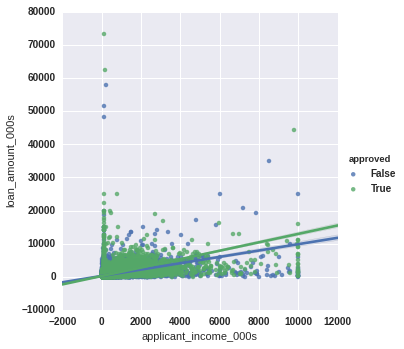

In [484]:
sns.lmplot(x="applicant_income_000s",y="loan_amount_000s",hue="approved",data=df_cat2_floatOnly)

In [485]:
df_cat2_floatOnly.corr()

,applicant_income_000s,hud_median_family_income,loan_amount_000s,minority_population,number_of_1_to_4_family_units,number_of_owner_occupied_units,population,tract_to_msamd_income,approved
applicant_income_000s,1.000000,0.142534,0.521781,-0.179422,0.000283,0.050412,-0.032172,0.276348,0.041056
hud_median_family_income,0.142534,1.000000,0.274942,-0.073578,-0.103639,-0.015203,-0.089151,-0.092001,0.054987
loan_amount_000s,0.521781,0.274942,1.000000,-0.223386,-0.024473,0.052664,-0.055609,0.369462,0.054001
minority_population,-0.179422,-0.073578,-0.223386,1.000000,-0.203341,-0.269708,0.149040,-0.478886,-0.062349
number_of_1_to_4_family_units,0.000283,-0.103639,-0.024473,-0.203341,1.000000,0.896431,0.802862,0.162408,0.006440
number_of_owner_occupied_units,0.050412,-0.015203,0.052664,-0.269708,0.896431,1.000000,0.779011,0.350361,0.024437
population,-0.032172,-0.089151,-0.055609,0.149040,0.802862,0.779011,1.000000,0.033982,-0.005771
tract_to_msamd_income,0.276348,-0.092001,0.369462,-0.478886,0.162408,0.350361,0.033982,1.000000,0.053026
approved,0.041056,0.054987,0.054001,-0.062349,0.006440,0.024437,-0.005771,0.053026,1.000000


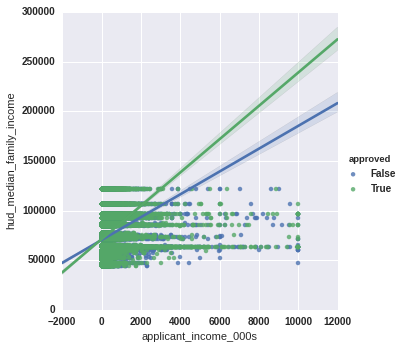

In [486]:
sns.lmplot(x="applicant_income_000s",y="hud_median_family_income",hue="approved",data=df_cat2_floatOnly)

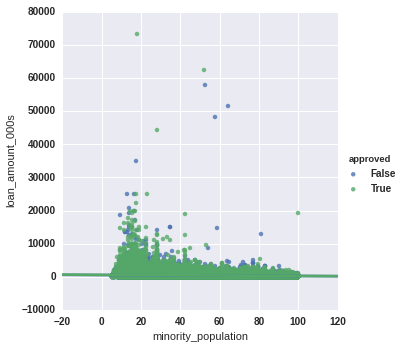

In [487]:
sns.lmplot(x="minority_population",y="loan_amount_000s",hue="approved",data=df_cat2_floatOnly)

## Model building

Now start the classfication. First create feature matrix and targed vector.

In [104]:
X=df_cat2.drop('approved', axis=1)

In [105]:
X.shape

(1652644, 86)

In [106]:
df_cat2.shape

(1652644, 87)

In [107]:
y=df_cat2['approved']

In [108]:
y.shape

(1652644,)

### Naive Bayes
as a first model, try Naive bayes

In [103]:
from sklearn.cross_validation import train_test_split

In [47]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,random_state=1)

In [ ]:
from sklearn.naive_bayes import GaussianNB
model=GaussianNB()
model.fit(Xtrain,ytrain)

In [497]:
y_model = model.predict(Xtest)

In [73]:
from sklearn.metrics import accuracy_score

In [505]:
accuracy_score(ytest,y_model)

0.67606090603905011

In [506]:
y_train=model.predict(Xtrain)

In [507]:
accuracy_score(ytrain,y_train)

0.67602379379144373

already slightly better than random, but not very impressive

In [48]:
from sklearn.cross_validation import cross_val_score

In [503]:
cross_val_score(model,X,y,cv=5)

array([ 0.52875844,  0.53103056,  0.52763903,  0.78681447,  0.94703928])

Dependent on the selection of training data - not very stable

### multinominal NB

In [508]:
from sklearn.naive_bayes import MultinomialNB

In [509]:
model=MultinomialNB()

In [513]:
cross_val_score(model,X,y,cv=5,n_jobs=1)

array([ 0.52752406,  0.54216423,  0.53010175,  0.57335362,  0.62555366])

## random forest classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [515]:
model=RandomForestClassifier(n_estimators=100)

In [516]:
cross_val_score(model,X,y,cv=5,n_jobs=1)

array([ 0.89248447,  0.87194165,  0.8973615 ,  0.91350835,  0.91921411])

Starts to look good!

In [67]:
model=RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0,n_jobs=8,verbose=1)

In [71]:
model.fit(Xtrain,ytrain)

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    6.8s remaining:    4.5s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    9.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=8, oob_score=False, random_state=0,
            verbose=1, warm_start=False)

In [74]:
y_model = model.predict(Xtest)
accuracy_score(ytest,y_model)

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.4s finished


0.90702655865389037

In [75]:
param_dist = {"max_depth": [3, None],
              "max_features": [3, 5, 10],
              "n_estimators": [10,50],
             # "min_samples_split": [2, 3, 5],
             # "min_samples_leaf": [2, 3, 5],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [39]:
clf=RandomForestClassifier(n_jobs=1,random_state=1)

In [40]:
from sklearn.model_selection import GridSearchCV

In [78]:
grid_search = GridSearchCV(clf, param_grid=param_dist)

In [530]:
from time import time

In [79]:
grid_search.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=3, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [3, 5, 10], 'n_estimators': [10, 50], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 'max_depth': [3, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [80]:
grid_search.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 10,
 'n_estimators': 50}

In [86]:
grid_search.grid_scores_

/home/jpavel/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.60515, std: 0.09781, params: {'max_features': 3, 'n_estimators': 10, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3},
 mean: 0.65602, std: 0.16983, params: {'max_features': 3, 'n_estimators': 50, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3},
 mean: 0.62861, std: 0.10106, params: {'max_features': 5, 'n_estimators': 10, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3},
 mean: 0.64604, std: 0.15346, params: {'max_features': 5, 'n_estimators': 50, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3},
 mean: 0.65126, std: 0.13619, params: {'max_features': 10, 'n_estimators': 10, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3},
 mean: 0.64400, std: 0.14674, params: {'max_features': 10, 'n_estimators': 50, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3},
 mean: 0.88704, std: 0.01981, params: {'max_features': 3, 'n_estimators': 10, 'bootstrap': True, 'criterion': 'gini', 'max_depth': None},
 mean: 0.89080, std: 0.02015, params: {'max_featur

In [87]:
param_dist2 = {"max_features": [10,15],
              "n_estimators": [50,100,200],
             # "min_samples_split": [2, 3, 5],
             # "min_samples_leaf": [2, 3, 5],
              "criterion": ["gini", "entropy"]}

In [88]:
grid_search2 = GridSearchCV(clf, param_grid=param_dist2)

In [89]:
grid_search2.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=3, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [10, 15], 'n_estimators': [50, 100, 200], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [90]:
grid_search2.grid_scores_

/home/jpavel/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.89400, std: 0.01877, params: {'max_features': 10, 'n_estimators': 50, 'criterion': 'gini'},
 mean: 0.89459, std: 0.01868, params: {'max_features': 10, 'n_estimators': 100, 'criterion': 'gini'},
 mean: 0.89495, std: 0.01889, params: {'max_features': 10, 'n_estimators': 200, 'criterion': 'gini'},
 mean: 0.89479, std: 0.01839, params: {'max_features': 15, 'n_estimators': 50, 'criterion': 'gini'},
 mean: 0.89533, std: 0.01848, params: {'max_features': 15, 'n_estimators': 100, 'criterion': 'gini'},
 mean: 0.89568, std: 0.01860, params: {'max_features': 15, 'n_estimators': 200, 'criterion': 'gini'},
 mean: 0.89438, std: 0.01864, params: {'max_features': 10, 'n_estimators': 50, 'criterion': 'entropy'},
 mean: 0.89475, std: 0.01885, params: {'max_features': 10, 'n_estimators': 100, 'criterion': 'entropy'},
 mean: 0.89501, std: 0.01888, params: {'max_features': 10, 'n_estimators': 200, 'criterion': 'entropy'},
 mean: 0.89493, std: 0.01838, params: {'max_features': 15, 'n_estimators': 5

In [41]:
param_dist3 = {"max_features": [15,None],
              "n_estimators": [200,500],
             # "min_samples_split": [2, 3, 5],
             # "min_samples_leaf": [2, 3, 5],
             # "criterion": ["gini", "entropy"]
              }

In [42]:
grid_search3 = GridSearchCV(clf, param_grid=param_dist3)

In [43]:
grid_search3.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [15, None], 'n_estimators': [200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [44]:
grid_search3.best_score_

0.89587836218810579

In [46]:
grid_search3.grid_scores_

/home/jpavel/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.89568, std: 0.01860, params: {'max_features': 15, 'n_estimators': 200},
 mean: 0.89588, std: 0.01849, params: {'max_features': 15, 'n_estimators': 500},
 mean: 0.89494, std: 0.01800, params: {'max_features': None, 'n_estimators': 200},
 mean: 0.89516, std: 0.01805, params: {'max_features': None, 'n_estimators': 500}]

In [64]:
from sklearn.ensemble import ExtraTreesClassifier
    

In [65]:
clf = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, criterion="entropy",max_features=None,n_jobs=2)

In [50]:
scores = cross_val_score(clf, X, y)

In [51]:
scores.mean()

0.88834077997206384

**Conclusion:** It was not faster and the result is worse, so do not continue with optimization

In [72]:
from sklearn.ensemble import GradientBoostingClassifier

In [74]:
clf2 = GradientBoostingClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=1)

In [76]:
param_dist4 = {"max_features": [10,15,None],
              "n_estimators": [100,200,500],
              "loss": ['deviance','exponential'],
               "learning_rate":[0.1,0.05,0.02],
               "max_depth":[3,5,7],
              }

In [77]:
grid_search4 = GridSearchCV(clf2, param_grid=param_dist4,n_jobs=2)

In [79]:
clf3 = GradientBoostingClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=1)

**Conclusion:** The result was never obtained - it took too long, possibly due to size of dataset